In [1]:
import pandas as pd
import numpy as np
import pickle, os, shutil, shap
from math import sqrt, log
from zipfile import ZipFile
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import cast,float32
from keras import backend as kb
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
import seaborn as sns

In [2]:
class Preprocessing():
    def __init__(self,k_size=6):
        self.k_size = k_size
        kmers = self.generate_kmers("",self.k_size)
        self.vectorizer = CountVectorizer(vocabulary = kmers)
        self.seqs = []
    
    def generate_kmers(self,current_kmer,current_depth):
        if current_depth == 1:
            return [current_kmer+"a",current_kmer+"t",current_kmer+"c",current_kmer+"g"]
        else:
            ret = self.generate_kmers(current_kmer+"a",current_depth-1)
            for nt in ['t','c','g']:
                ret += self.generate_kmers(current_kmer+nt,current_depth-1)
            return ret
    
    def generate_kmer_multiple(self,seqlist,k):
        kmer_list = []
        n = -1
        for seq in seqlist:
            kmer_list.append(self.generate_kmer_single(str(seq),k))
        return kmer_list
    
    def generate_kmer_single(self,seq,k):
        kmer = ""
        for i in range(0,len(seq)-k,1):
            kmer += seq[i:i+k]+" "
        return kmer[:-1]
    
    def CountKmers(self,seqs):
        if type(seqs) in [type([]),type(pd.core.series.Series([1]))]:
            kmer = self.generate_kmer_multiple(seqs, self.k_size)
            transformed_X = self.vectorizer.transform(kmer).toarray()
            return transformed_X
        else:
            raise ValueError("""Invalid 'seqs' format.
            Expected formats are 'list' or 'pandas.core.series.Series'.""")
            
    def ReadFASTA(self,filename,as_pd=True):
        if filename.split(".")[-1] not in ["fasta","fna","fa"]:
            raise ValueError('Invalid file format. Expected formats are ["fasta","fna","fa"].')
        file_handle = open(filename,"r")
        seqs = []
        seqid = []
        tmp_seq = ""
        for line in file_handle:
            if (line[0] == ">"):
                if tmp_seq != "":
                    seqs.append(tmp_seq)
                seqid.append(line.split("\n")[0][1:])
                tmp_seq = ""
            else:
                tmp_seq+=line.split("\n")[0]
        seqs.append(tmp_seq)
        file_handle.close()
        if as_pd:
            fasta = {}
            for i in range(len(seqs)):
                fasta[seqid[i]] = seqs[i]
            return pd.DataFrame(fasta,index=["sequence"]).transpose()["sequence"]
        else:
            return seqs, seqid

### Load Results

In [3]:
da0 = pd.read_csv("datasets/full_length_reads.csv")
da1 = pd.read_csv("4.final_test/datasets/full_length_testdata.csv")
da = pd.concat([da0,da1],axis=0)
da.index = [i for i in range(da.shape[0])]
X = da["sequence"]
Y = da['copy_number']
pp = Preprocessing()
X = pp.CountKmers(seqs=X)
X_with_indices = pd.concat([pd.DataFrame(X, columns = pp.vectorizer.get_feature_names_out()),
           pd.DataFrame([i for i in range(27579)],columns = ["index"])],axis = 1)
indices = pd.read_csv("explainability/selected_X_test.csv")
X_test = X_with_indices.merge(indices,how="inner",on=["index"])
X_test = X_test.iloc[:,0:4096]

In [4]:
shap_values = pd.read_csv("explainability/shap_values.csv")
shap_values = [np.array(shap_values.values.tolist())]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


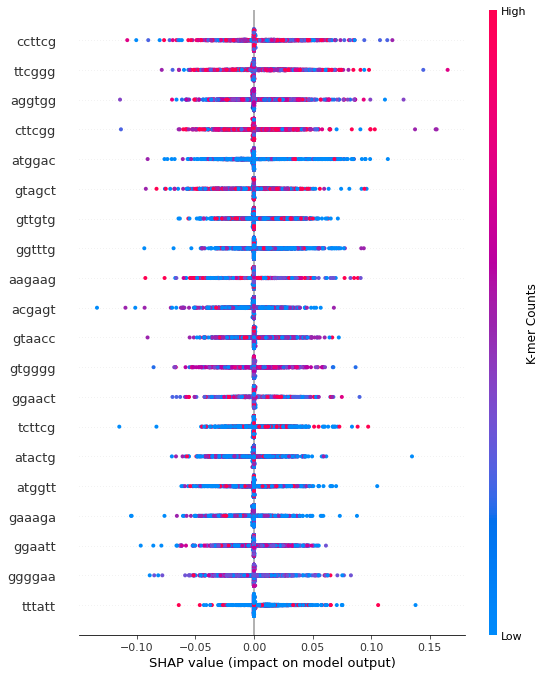

In [5]:
shap.summary_plot(shap_values[0], X_test,show=False, color_bar_label='K-mer Counts')
plt.savefig('figures/summary_plot1.pdf')

In [5]:
kmer_names = list(X_test.columns)
kmer_dict = {}
for i in range(0,len(kmer_names)):
    kmer_dict[kmer_names[i]] = i

maxlen = X_test.sum(axis=1).max()

### Information Content & SHAP values

In [6]:
da0 = pd.read_csv("datasets/full_length_reads.csv")
da1 = pd.read_csv("4.final_test/datasets/full_length_testdata.csv")
da = pd.concat([da0,da1],axis=0)
da.index = [i for i in range(da.shape[0])]
X = da["sequence"]
Y = da['copy_number']
X_with_indices = pd.concat([pd.DataFrame(X, columns = ["sequence"]),
           pd.DataFrame([i for i in range(27579)],columns = ["index"])],axis = 1)
X_test_seqs = X_with_indices.merge(indices,how="inner",on=["index"])
X_test_seqs = X_test_seqs["sequence"]
kmer_list = pp.generate_kmer_multiple(X_test_seqs.tolist(),k=6)

In [7]:
# Map SHAP values
mapped_shap = []
shaps = shap_values[0].tolist()
for j in range(0,len(kmer_list)):
    line = kmer_list[j]
    seq_as_kmer_list = line.split(" ")
    mapped_line = []
    for i in range(0,len(seq_as_kmer_list)):
        word = seq_as_kmer_list[i]
        index = kmer_dict.get(word.lower())
        if index != None:
            shap_value = shaps[j][index]
        else:
            shap_value = 0
        mapped_line.append(shap_value)
    mapped_line += [0]*(maxlen-len(mapped_line))
    mapped_shap.append(mapped_line)

In [8]:
# Load Sequence Alignment
file_handle = open("tree/full_length_whole_aln.fasta","r")
seq = []
seqid = []
tmp_seq = ""
for line in file_handle:
    if (line[0] == ">"):
        if tmp_seq != "":
            seq.append(tmp_seq)
        seqid.append(line.split("\n")[0][1:])
        tmp_seq = ""
    else:
        tmp_seq+=line.split("\n")[0]
seq.append(tmp_seq)
file_handle.close()

In [9]:
e_coli = seq[17929] # 17929 is the index of E. coli, accession number: GCF_002953035.1

In [10]:
seq_select = []
for index in indices["index"].tolist():
    seq_select.append(seq[index])

In [11]:
# Map SHAP values to alignment
aln_shap_values = []
for i in range(0,len(seq_select)):
    nt_list = list(seq_select[i])
    shap_value_list = mapped_shap[i]
    aln_shap_single = []
    j = 0
    for nt in nt_list:
        if nt != "-":
            if j < len(shap_value_list):
                aln_shap_single.append(shap_value_list[j])
            else:
                aln_shap_single.append(np.nan)
            j+=1
        else:
            aln_shap_single.append(np.nan)
    aln_shap_values.append(aln_shap_single)

In [12]:
posit_mean_shap = pd.DataFrame(aln_shap_values).abs().mean().values.tolist()

In [13]:
# Aggregate the counts of nucleotides of each position
nt_sum = []
for j in range(0,len(seq_select[0])):
    nt_count = {"a":0,"t":0,"c":0,"g":0,"-":0,"res":0}
    for i in range(0,len(seq_select)):
        nt = seq_select[i][j]
        if nt in ["a","t","c","g","-"]:
            nt_count[nt]+=1
        else:
            nt_count["res"]+=1
    nt_sum.append(nt_count)

In [14]:
nt_sum = pd.DataFrame(nt_sum).values.tolist()

In [15]:
# Investigate Mutations and Information Content
nt2index = {"a":0,"t":1,"c":2,"g":3,"-":4,"res":5}
mutation_and_shaps = []
e_n = 5/(2*len(seq_select)*math.log(2))


degree_of_conservation = []


for i in range(len(nt_sum)):
    position = nt_sum[i]
    n_sites = sum(position)
    substituion = 0
    insertion = 0
    deletion = 0
    H = 0
    curr_nt = e_coli[i]
    if curr_nt == '-':
        insertion = n_sites - position[4]
        insertion = insertion/n_sites
    else:
        deletion = position[4]
        substituion = n_sites - position[nt2index[curr_nt]] - deletion
        deletion = deletion/n_sites
        substituion = substituion/n_sites
    
    for char_count in position:
        if char_count == 0:
            H -= 0
        else:
            char_freq = char_count/n_sites
            H = H - char_freq * math.log2(char_freq)
    R = math.log2(6)-e_n-H
    R = R * sum(position[0:4])/n_sites
    
    mutation_and_shaps.append([i,substituion,deletion,insertion,posit_mean_shap[i],R])
    
mutation_and_shaps = pd.DataFrame(mutation_and_shaps,
                                  columns=["Position","Substitution","Deletion","Insertion","SHAP","ShannonEntropy"])

aligned_to_unaligned = {}
index = 0
for i in range(len(e_coli)):
    nt = e_coli[i]
    if nt != "-":
        index += 1
    aligned_to_unaligned[i] = index

aligned_to_unaligned = pd.DataFrame(aligned_to_unaligned, index=["E. coli Coordinate"]).transpose()
aligned_to_unaligned["Position"] = aligned_to_unaligned.index
mutation_and_shaps = pd.merge(mutation_and_shaps,aligned_to_unaligned,on=["Position"])
mutation_and_shaps = mutation_and_shaps.dropna(subset = ["SHAP"])
mutation_and_shaps["Position"] = [i for i in range(mutation_and_shaps.shape[0])]

In [18]:
mutation_and_shaps.to_csv("explainability/shaps_and_mutations.csv",index=False)

In [16]:
groupby = mutation_and_shaps.groupby("E. coli Coordinate").mean()
groupby["E. coli Coordinate"] = groupby.index
groupby.index = groupby.index.tolist()

In [17]:
max_shap = groupby["SHAP"].max()

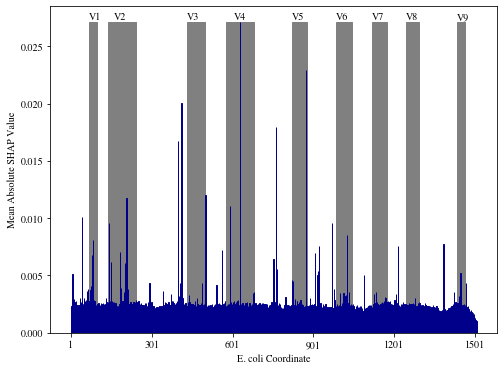

In [18]:
plt.rcParams["font.family"] = "Times"
fig, axs = plt.subplots(1, 1, sharex=True)
pad = 0.0002
# V1
axs.add_patch(Rectangle((69, 0), 99-69, max_shap, color='grey'))
axs.text(69,max_shap+pad,"V1")
# V2
axs.add_patch(Rectangle((137, 0), 242-137, max_shap, color='grey'))
axs.text(162,max_shap+pad,"V2")
# V3
axs.add_patch(Rectangle((433, 0), 497-433, max_shap, color='grey'))
axs.text(433,max_shap+pad,"V3")
# V4
axs.add_patch(Rectangle((576, 0), 682-576, max_shap, color='grey'))
axs.text(606,max_shap+pad,"V4")
# V5
axs.add_patch(Rectangle((822, 0), 879-822, max_shap, color='grey'))
axs.text(822,max_shap+pad,"V5")
# V6
axs.add_patch(Rectangle((986, 0), 1043-986, max_shap, color='grey'))
axs.text(986,max_shap+pad,"V6")
# V7
axs.add_patch(Rectangle((1117, 0), 1173-1117, max_shap, color='grey'))
axs.text(1117,max_shap+pad,"V7")
# V8
axs.add_patch(Rectangle((1243, 0), 1294-1243, max_shap, color='grey'))
axs.text(1243,max_shap+pad,"V8")
# V9
axs.add_patch(Rectangle((1435, 0), 1465-1435, max_shap, color='grey'))
axs.text(1435,max_shap+pad,"V9")

axs.bar(x=groupby["E. coli Coordinate"],height=groupby["SHAP"],
        width=1,color='darkblue',edgecolor='darkblue')
axs.set_xticks([i for i in range(1,1502,300)])
axs.set_xlabel("E. coli Coordinate")
axs.set_ylabel("Mean Absolute SHAP Value")
fig.set_size_inches(8, 6, forward=True)
fig.savefig("figures/SHAP_Position.pdf")

### Mapping SHAP values 

In [18]:
top_kmers = list(pd.DataFrame(shap_values[0],
                              columns = pp.vectorizer.get_feature_names()).abs().max().nlargest(100).index)

mapped_shap = []
shaps = shap_values[0].tolist()
for j in range(0,len(kmer_list)):
    line = kmer_list[j]
    seq_as_kmer_list = line.split(" ")
    mapped_line = []
    for i in range(0,len(seq_as_kmer_list)):
        word = seq_as_kmer_list[i]
        if word.lower() in top_kmers:
            index = kmer_dict.get(word.lower())
            shap_value = shaps[j][index]
            mapped_line.append(shap_value)
        else:
            mapped_line.append(np.nan)
    mapped_line += [0]*(maxlen-len(mapped_line))
    mapped_shap.append(mapped_line)

In [19]:
filtered_shap = []
for i in range(0,len(mapped_shap)):
    for j in range(0,len(mapped_shap[0])):
        if mapped_shap[i][j] not in [np.nan,0]:
            filtered_shap.append([i,j,mapped_shap[i][j]])
            
filtered_shap = pd.DataFrame(filtered_shap,columns = ["sample","position","shap_value"])
filtered_shap.to_csv("explainability/unaln_top_shap.csv",index=False)

### Prepare downstream BLAST

In [9]:
da0 = pd.read_csv("datasets/full_length_reads.csv")
da1 = pd.read_csv("4.final_test/datasets/full_length_testdata.csv")
da = pd.concat([da0,da1],axis=0)
da.index = [i for i in range(da.shape[0])]
da_with_indices = pd.concat([da,
           pd.DataFrame([i for i in range(27579)],columns = ["index"])],axis = 1)
da_test = da_with_indices.merge(indices,how="inner",on=["index"])

In [11]:
accession = da_test["accession"]
sequence = da_test["sequence"]

In [14]:
file_handle = open("blast/conserved_blast/selected_sequences.fasta","w")
for i in range(len(accession)):
    file_handle.write(">"+accession[i]+"\n")
    file_handle.write(sequence[i]+"\n")
file_handle.close()